In [92]:
# Importing all required packages
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import ipywidgets as widgets
import tensorflow as tf
from keras.layers import Dense,LSTM,Dropout,Flatten
from keras import Sequential
from keras import backend as K
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score
import warnings
warnings.filterwarnings('ignore')

selection_made = False
initial_balance = 10000

In [93]:
# Define the function to update the 'ticker' variable
def update_ticker(change):
    global tick
    tick = change.new
    selection_made = True

# Define dropdown menu
dropdown = widgets.Dropdown(
    options=['AAPL', 'GOOGL', 'MSFT'],  # Example ticker symbols
    value='AAPL',
    description='Select Ticker:'
)

# Register the dropdown change handler
dropdown.observe(update_ticker, names='value')

# Display the dropdown
display(dropdown)


Dropdown(description='Select Ticker:', options=('AAPL', 'GOOGL', 'MSFT'), value='AAPL')

In [94]:
def create_dataset(ticker):
    if selection_made:
        tick = ticker
    # Gather data, preprocess, and add return column
    df = yf.download(ticker)
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= '2018-01-01']
    df['Return'] = (df['Adj Close'] - df['Open']) / df['Open']
    return df

data = create_dataset(tick)
data.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.670975,102223600,-0.043936
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.663891,118071600,-0.057233
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.852768,89738400,-0.052909
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.317902,94640000,-0.047096
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.164436,82271200,-0.055591


In [95]:
def candlestick_chart(df, ticker):
    # Create both 50 and 200 day moving average
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()

    # Group into monthly for the candlesticks
    monthly_data = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    # Create trace for the candlesticks
    candlestick = go.Candlestick(x=monthly_data.index,
                    open=monthly_data['Open'],
                    high=monthly_data['High'],
                    low=monthly_data['Low'],
                    close=monthly_data['Close'],
                    name='Candlestick')

    #Create trace for moving averages, intially set to not be visible
    ma_50 = go.Scatter(x=df.index, y=df['MA50'], mode='lines', name='50-Day MA', line=dict(color='grey'), visible = False)
    ma_200 = go.Scatter(x=df.index, y=df['MA200'], mode='lines', name='200-Day MA', line=dict(color='black'), visible = False)

    # Create buttons to toggle moving averages
    button_50 = dict(label='50-Day MA', method='update', args=[{'visible': [True, True, False]}, {'title': f'({ticker}) - 50-Day MA'}])
    button_200 = dict(label='200-Day MA', method='update', args=[{'visible': [True, False, True]}, {'title': f'({ticker}) - 200-Day MA'}])
    button_both = dict(label='Both', method='update', args=[{'visible': [True, True, True]}, {'title': f'({ticker})'}])
    button_none = dict(label='None', method='update', args=[{'visible': [True, False, False, False]}, {'title': f'({ticker})'}])

    # Creating button menu
    updatemenus = list([
        dict(active=3,
            buttons=[button_50, button_200, button_both, button_none],
            x=1.0,
            y=1.0,
            xanchor='right',
            yanchor='top',
            pad=dict(t=0, r=10),
            showactive=True)
    ])


    # Updating layout of figure
    layout = dict(title=f'{ticker} Stock Price',
                xaxis_title='Date',
                yaxis_title='Stock Price ($)',
                updatemenus=updatemenus)

    # Create and display figure
    fig = go.Figure(data=[candlestick, ma_50, ma_200], layout=layout)
    fig.show()

candlestick_chart(data, tick)

In [96]:
def yearly_returns(df, ticker):
    yearly_returns = []

    # Group data and calculate yearly return
    for year in range(df.index.min().year, df.index.max().year + 1):
        start_date = pd.Timestamp(year, 1, 1)
        # Get the last trading day of the year
        end_date = df[df.index.year == year].index.max()
        year_data = df[(df.index >= start_date) & (df.index <= end_date)]
        start_price = year_data.iloc[0]['Open']
        end_price = year_data.iloc[-1]['Close']
        yearly_return = ((end_price - start_price) / start_price) * 100
        yearly_return = round(yearly_return, 2)
        yearly_returns.append((year, yearly_return))

    # Plot yearly returns
    yearly_returns_df = pd.DataFrame(yearly_returns, columns=['Year', 'Yearly_Return'])
    bar_trace = go.Bar(x=yearly_returns_df['Year'], y=yearly_returns_df['Yearly_Return'],
                       marker=dict(color='skyblue'))

    layout = go.Layout(title=f'Yearly Returns of {ticker} (2018-2024)',
                       xaxis=dict(title='Year'),
                       yaxis=dict(title='Yearly Return (%)'))

    fig = go.Figure(data=[bar_trace], layout=layout)
    fig.show()

yearly_returns(data, tick)


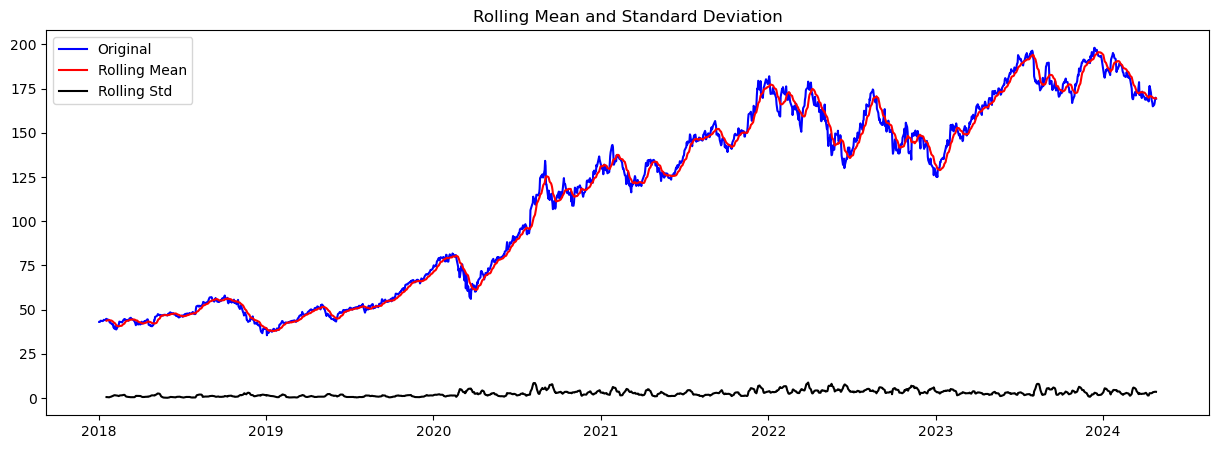

Results of dickey fuller test
Test Statistics                  -1.064028
p-value                           0.729202
No. of lags used                  0.000000
Number of observations used    1589.000000
dtype: float64


False

In [97]:
# Test if the data is stationary and visualize it
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)
    is_stationary = adft[1] < 0.05
    return is_stationary

test_stationarity(data['Close'])

In [98]:
def create_arima(df, ticker):
   # Split data into training and testing sets
   model_name = "ARIMA"
   df_train = df[df.index < '2023-02-02']
   df_valid = df[df.index >= '2023-02-02']
   train = df_train['Close'].values
   test = df_valid['Close'].values

   # Find the optimal p,d,q
   model = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=5, max_q=5,
                   m=1, d=None, seasonal=False,
                   start_P=0, D=0,
                   trace=False, error_action='ignore',
                   suppress_warnings=True, stepwise=True)
   
   p, d, q = model.order
   optimal_values = p,d,q
   history = [x for x in train]
   predictions = list()

   # Train the model using optimal p,d,q values
   for t in range(len(df_valid)):
      model = ARIMA(history, order=(optimal_values))
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      obs = test[t]
      history.append(obs)

   #Calculate accuracy of model
   rmse_arima = math.sqrt(mean_squared_error(test, predictions))
   threshold = 1
   actual_prices = df_valid['Close']
   percentage_changes = ((predictions - actual_prices) / actual_prices) * 100
   correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)
   rate_arima = (correct_predictions / len(actual_prices)) * 100

   # Display model results
   fig = go.Figure()
   fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price ($)", title = f"Actual vs. Forecasted Closing Price of {ticker} (ARIMA)")
   fig.add_trace(go.Scatter(x=df_train.index,y=df_train.Close,name='Training Data'))
   fig.add_trace(go.Scatter(x=df_valid.index,y=df_valid.Close,name='Testing Data'))
   fig.add_trace(go.Scatter(x=df_valid.index,y=predictions,name='Forecasted Data'))
   fig.show()

   # Print accuracy rates of model
   print("Hit Rate: %.2f%%" % rate_arima)
   print('Test RMSE: %.3f' % rmse_arima)

   return predictions, test, rmse_arima, rate_arima, model_name

arima_variables = create_arima(data, tick)

Hit Rate: 65.16%
Test RMSE: 2.227


In [99]:
def create_lstm(df, ticker):
    # Splitting data into training and testing sets
    model_name = str("LSTM")
    df_train = df[df.index < '2023-02-02']
    df_valid = df[df.index >= '2023-02-02']
    train_lstm = df_train['Close'].values
    test_lstm = df_valid['Close'].values

    # Pre-process data for LSTM model; Scaling and reshaping data
    scaler = MinMaxScaler(feature_range=(0,1))
    training_values = np.reshape(train_lstm,(len(train_lstm),1))
    test_values = np.reshape(test_lstm, (len(test_lstm), 1))
    scaled_training_values = scaler.fit_transform(training_values)
    scaled_test_values = scaler.transform(test_values)

    # Assigning training values to the training data
    x_train = scaled_training_values[:-1]
    y_train = scaled_training_values[1:]

    # Reshape the data for LSTM
    x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))

    # Creating, compiling, training the model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size=50, verbose=0)

    # Make predictions on the test data
    predicted_price_scaled = model.predict(scaled_test_values[:-1])

    # Inverse transform the predicted values
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    predicted_price = np.squeeze(predicted_price)

    # Plotting the model results
    fig = go.Figure()
    fig.update_layout(xaxis_title="Date", yaxis_title="Stock Price ($)", title = f"Actual vs. Forecasted Closing Price of {ticker} (LSTM)")
    fig.add_trace(go.Scatter(x=df_train.index, y=df_train.Close, name='Training Data'))
    fig.add_trace(go.Scatter(x=df_valid.index, y=df_valid.Close, name='Testing Data'))
    fig.add_trace(go.Scatter(x=df_valid.index[:-1], y=predicted_price, name='Forecasted Data'))
    fig.show()

    # Calculate the RMSE
    rmse_lstm = math.sqrt(mean_squared_error(test_lstm[1:], predicted_price))

    # Calculate the hit rate
    threshold = 1
    actual_prices = df_valid['Close'].values[1:]
    percentage_changes = ((predicted_price - actual_prices) / actual_prices) * 100
    correct_predictions = np.sum(np.abs(percentage_changes) <= threshold)
    rate_lstm = (correct_predictions / len(actual_prices)) * 100

    print("Hit Rate: %.2f%%" % rate_lstm)
    print('Test RMSE: %.3f' % rmse_lstm)

    return predicted_price, test_lstm[1:], rmse_lstm, rate_lstm, model_name

lstm_variables = create_lstm(data, tick)

10/10 [==============================] - 1s 2ms/step


Hit Rate: 48.22%
Test RMSE: 2.688


In [100]:
def compare_models(arima_variables, lstm_variables):
    if arima_variables[3] > lstm_variables[3]:
        print("The ARIMA model is the more accurate model.")
        return arima_variables
    else:
        print("The LSTM model is the more accurate model.")
        return lstm_variables
    
chosen_model = compare_models(arima_variables, lstm_variables)

The ARIMA model is the more accurate model.


In [101]:
# Creating two trading strategies to compare

def buy_and_hold(initial_balance, closing_prices):
    initial_price = closing_prices[0]  # Initial closing price
    final_price = closing_prices[-1]   # Final closing price
    shares_bought = initial_balance / initial_price  # Calculate the number of shares bought
    final_balance = shares_bought * final_price  # Calculate the ending balance after selling at the final price
    return final_balance


def model_trading_strategy(initial_balance, actual_prices, predictions):
    balance = initial_balance
    position_open = False
    buy_price = None
    shares = 0

    for i in range(1, len(predictions)):
        if predictions[i] > predictions[i - 1] and not position_open:
            buy_price = actual_prices[i-1]
            shares = balance / buy_price
            balance -= shares * buy_price
            position_open = True
        elif predictions[i] < predictions[i - 1] and position_open:
            sell_price = actual_prices[i-1]
            balance += shares * sell_price
            shares = 0
            position_open = False

    if position_open:  # Close position if still open at the end
        balance += shares * actual_prices[-1]

    return balance

In [102]:
# Call functions and display output
actual_prices = chosen_model[1]
predictions = chosen_model[0]
ending_balance_model = model_trading_strategy(initial_balance, predictions, actual_prices)
print(f"Ending Balance for {chosen_model[4]} Strategy: ${ending_balance_model:.2f}")
ending_balance_bah = buy_and_hold(initial_balance, actual_prices)
print("Ending Balance for Buy and Hold Strategy: ${:.2f}".format(round(ending_balance_bah, 2)))

Ending Balance for ARIMA Strategy: $11822.95
Ending Balance for Buy and Hold Strategy: $11225.30
